In [49]:
import sys
import torch
import numpy as np
import pickle as pkl
import os

sys.path.append('../../../')


from experiments.supervised.product_manifold.script import product_manifold, plot_networks
from riemannian_geometry.computations.pullback_metric import pullback_all_metrics
from models.supervised.mlp.model import MLP

models_path = "../../../models/supervised/mlp/saved_models"


In [2]:
np.random.seed(2)
torch.manual_seed(2)

In [51]:
size = "2_wide"
mode = "moon"
epoch = 5
model = MLP(2,7,2,2)
with open(f'{models_path}/{size}/mlp_{mode}/dataset.pkl', 'rb') as f:
	dataset = pkl.load(f)

full_path = f'{models_path}/{size}/mlp_{mode}/model_{epoch}.pth'
model.load_state_dict(torch.load(full_path))
if size == "overfit":
	model.num_layers -= 1
	model.layers = model.layers[:-1]
model.eval()


MLP(
  (layers): ModuleList(
    (0-5): 6 x Layer(
      (act_func): Tanh()
      (linear_map): Linear(in_features=2, out_features=2, bias=True)
    )
    (6): Layer(
      (act_func): Sigmoid()
      (linear_map): Linear(in_features=2, out_features=2, bias=True)
    )
  )
)

In [52]:
N=50
wrt = "output_wise"
sigma = 0.05

X = torch.from_numpy(dataset.X).float()
labels = dataset.y


model.forward(X, save_activations=True)

activations = model.get_activations()
activations_np = [a.detach().numpy() for a in activations]
g, dg, ddg, surface = pullback_all_metrics(model, activations, N, wrt=wrt, method="manifold", sigma=sigma, normalised=False)
	

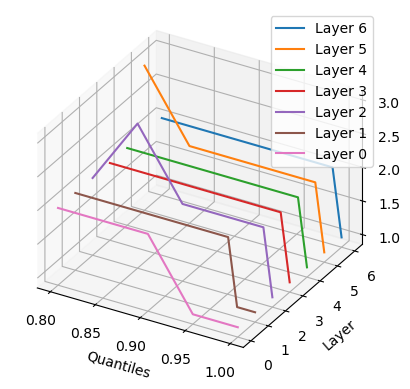

In [53]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d', proj_type='ortho')
ax.set_xlabel('Quantiles')
ax.set_ylabel('Layer')
ax.set_zlabel('Number of components')

for layer in reversed(range(0, len(model.layers))):
    indices = np.arange(len(activations_np[layer]))
    surface_ = surface[layer][indices].copy()
    activations_np_ = activations_np[layer][indices].copy()
    g_ = g[layer][indices].copy()

    V = np.linalg.norm(g_, axis=(1,2), ord="fro")

    components_pin, graphs_pin, removed_nodes, quantiles = product_manifold(surface_, V, plot=False, size=size, mode=mode, use_pin=False)

    ax.plot(quantiles, layer*np.ones_like(quantiles), zs=[len(c) for c in components_pin[1:]], label=f"Layer {layer}")
plt.legend()
ax.legend(loc='upper right')
if not os.path.exists(f"figures/{mode}/{size}"):
    os.makedirs(f"figures/{mode}/{size}")
plt.savefig(f"figures/{mode}/{size}/components_3d.png")